#### Analyzing Bike Sharing Trends

## Problem Statement
With environmental issues and health becoming trending topics, usage of bicycles as a mode of transportation has gained traction in recent years. To encourage bike usage, cities across the world have successfully rolled out bike sharing programs. Under such schemes, riders can rent bicycles using manual/ automated kiosks spread across the city for defined periods. In most cases, riders can pick up bikes from one location and return them to any other designated place.

The bike sharing platforms from across the world are hotspots of all sorts of data, ranging from travel time, start and end location, demographics of riders, and so on. This data along with alternate sources
of information such as weather, traffic, terrain, and so on makes it an attractive proposition for different research areas.

The Capital Bike Sharing dataset contains information related to one such bike sharing program underway in Washington DC. Given this augmented (bike sharing details along with weather information) dataset, can we forecast bike rental demand for this program?

## Exploratory Analysis
Now that we have an overview of the business case and a formal problem statement, the very next stage is to explore and understand the data.

### Load Packages

In [47]:
# data manipulation
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# modeling utilities
import scipy.stats as stats
import pydotplus 
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
from sklearn import  linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeRegressor

sns.set_style('whitegrid')
sns.set_context('talk')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

### Preprocessing

In [3]:
df_hour = pd.read_csv('data/hour.csv')
print("Shape of dataset::{}".format(df_hour.shape))

Shape of dataset::(17379, 17)


In [4]:
df_hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [5]:
df_hour.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

As mentioned in the documentation for the dataset, there are bike sharing as well as weather attributes available. The attribute dteday would require type conversion from object (or string type) to timestamp. Attributes like season, holiday, weekday, and so on are inferred as integers by pandas, and they would require conversion to categoricals for proper understanding.

Before jumping into type casting attributes, the following snippet cleans up the attribute names to make them more understandable and pythonic.

In [6]:
df_hour.rename(columns={'instant':'rec_id',
                        'dteday':'datetime',
                        'holiday':'is_holiday',
                        'workingday':'is_workingday',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_count',
                        'hr':'hour','yr':'year'},inplace=True)

Now that we have attribute names cleaned up, we perform type-casting of attributes. The following snippet gets the attributes into the proper data types.

In [7]:
# date time conversion
df_hour['datetime'] = pd.to_datetime(df_hour.datetime)

# categorical variables
df_hour['season'] = df_hour.season.astype('category')
df_hour['is_holiday'] = df_hour.is_holiday.astype('category')
df_hour['weekday'] = df_hour.weekday.astype('category')
df_hour['weather_condition'] = df_hour.weather_condition.astype('category')
df_hour['is_workingday'] = df_hour.is_workingday.astype('category')
df_hour['month'] = df_hour.month.astype('category')
df_hour['year'] = df_hour.year.astype('category')
df_hour['hour'] = df_hour.hour.astype('category')

### Distribution and Trends

[Text(0.5,1,'Season wise hourly distribution of counts')]

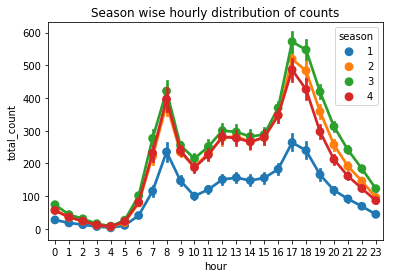

In [9]:
fig,ax = plt.subplots()
sns.pointplot(data=df_hour[['hour',
                           'total_count',
                           'season']],
             x='hour', y='total_count',
             hue='season', ax=ax)
ax.set(title="Season wise hourly distribution of counts")

The plot above shows similar trends for all seasons with counts peaking in the morning between 7-9 am and in the evening between 4-6 pm, possibly due to high movement during start and end of office hours. The counts are lowest for the spring season, while fall sees highest riders across all 24 hours.

[Text(0.5,1,'Weekday wise hourly distribution of counts')]

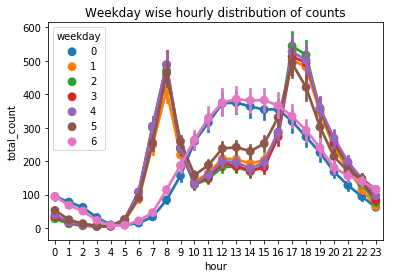

In [10]:
fig,ax = plt.subplots()
sns.pointplot(data=df_hour[['hour',
                           'total_count',
                           'weekday']],
             x='hour', y='total_count',
             hue='weekday', ax=ax)
ax.set(title="Weekday wise hourly distribution of counts")

Similarly, distribution of ridership across days of the week also presents interesting trends of higher usage during afternoon hours over weekends, while weekdays see higher usage during mornings and evenings.

Having observed hourly distribution of data across different categoricals, let’s see if there are any aggregated trends.

[Text(0.5,1,'Monthly distribution of counts')]

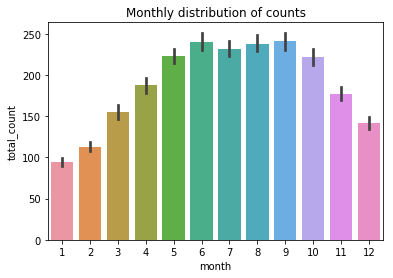

In [11]:
fig,ax = plt.subplots()
sns.barplot(data=df_hour[['month',
                         'total_count']],
           x="month",y="total_count")
ax.set(title="Monthly distribution of counts")

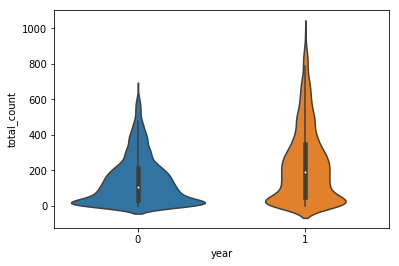

In [15]:
sns.violinplot(data=df_hour[['year',
                            'total_count']],
              x="year",y="total_count")

The following snippet plots yearly distribution on violin plots. The figure above clearly helps us understand the multimodal distribution in both 2011 and 2012 ridership counts with 2011 having peaks at lower values as compared to 2012. The spread of counts is also much more for 2012, although the max density for both the years is between 100-200 rides.

### Outliers
While exploring and learning about any dataset, it is imperative that we check for extreme and unlikely values. Though we handle missing and incorrect information while preprocessing the dataset, outliers are usually caught during EDA. Outliers can severely and adversely impact the downstream steps like modeling and the results.
We usually utilize boxplots to check for outliers in the data. In the following snippet, we analyze outliers for numeric attributes like total_count, temperature, and wind_speed.

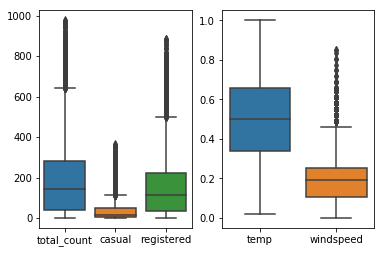

In [16]:
fig,(ax1,ax2)= plt.subplots(ncols=2)
sns.boxplot(data=df_hour[['total_count','casual','registered']],ax=ax1)
sns.boxplot(data=df_hour[['temp','windspeed']],ax=ax2)

We can easily mark out that for the three count related attributes, all of them seem to have a sizable number of outlier values. The casual rider distribution has overall lower numbers though. For weather attributes of temperature and wind speed, we find outliers only in the case of wind speed.

We can similarly try to check outliers at different granularity levels like hourly, monthly, and so on. 

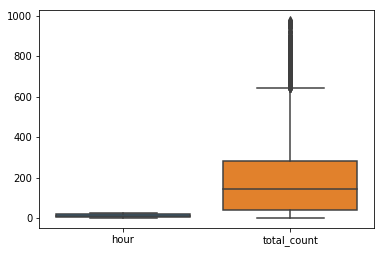

In [17]:
fig,ax= plt.subplots()
sns.boxplot(data=df_hour[['hour','total_count']],ax=ax)

### Correlations

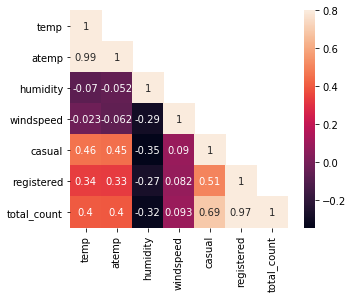

In [19]:
corrMatt = df_hour[['temp','atemp',
                   'humidity','windspeed',
                   'casual', 'registered',
                   'total_count']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
sns.heatmap(corrMatt, mask=mask,
           vmax=.8, square=True,annot=True)

The two count variables, registered and casual, show obvious strong correlation to total_count. Similarly, temp and atemp show high correlation. wind_speed and humidity have slight negative correlation. Overall, none of the attributes show high correlational statistics.

## Regression Analysis
Regression analysis is a statistical modeling technique. It is the process of investigating relationships between dependent and independent variables. Regression itself includes a variety of techniques for modeling and analyzing relationships between variables. It is widely used for predictive analysis, forecasting, and time series analysis.
The dependent or target variable is estimated as a function of independent or predictor variables. The estimation function is called the regression function.

The height-weight relationship is a classic example to get started with regression analysis. The example states that weight of a person is dependent on his/her height. Thus, we can formulate a regression function to estimate the weight (dependent variable) given height (independent variable) of a person, provided we have enough training examples. We discuss more on this in the coming section.

Regression analysis models the relationship between dependent and independent variables. It should be kept in mind that correlation between dependent and independent variables does not imply causation!

### Assumptions
Assumptions
Regression analysis has a few general assumptions while specific analysis techniques have added (or reduced) assumptions as well. The following are important general assumptions for regression analysis:
* The training dataset needs to be representative of the population being modeled.
* The independent variables are linearly independent, i.e., one independent variable cannot be explained as a linear combination of others. In other words, there should be no multicollinearity.
* Homoscedasticity of error, i.e. the variance of error, is consistent across the sample.

### Evaluation Criteria
Evaluation of model performance is an important aspect of modelling. We should be able to not just understand the outcomes but also evaluate how models compare to each other or whether the performance is acceptable or not.
In general, evaluation metrics and performance guidelines are pretty use case and domain specific, regression analysis often uses a few standard metrics.

#### Residual Analysis
Regression is an estimation of target variable using the regression function on explanatory variables. Since the output is an approximation, there will be some difference between the predicted value of target and the observed value.
Residual is the difference between the observed and the predicted (output of the regression function). Mathematically, the residual or difference between the observed and the predicted value of the ith data point is given as:

$$e_i= y_i -f_i(x_i,\beta)$$

A regression model that has nicely fit the data will have its residuals display randomness (i.e., lack of any pattern). This comes from the homoscedasticity assumption of regression modeling. Typically scatter plots between residuals and predictors are used to confirm the assumption. Any pattern, results in a violation of this property and points toward a poor fitting model.

#### Normality Test (Q-Q Plot)
This is a visual/graphical test to check for normality of the data. This test helps us identify outliers, skewness, and so on. The test is performed by plotting the data verses theoretical quartiles. The same data is also plotted on a histogram to confirm normality. Any deviation from the straight line in normal plot or skewness/multi-modality in histogram shows that the data does not pass the normality test.

#### R-Squared: Goodness of Fit
R-Squared or the coefficient of determination is another measure used to check for goodness of fit for regression analysis. It is a measure used to determine if the regression line is able to indicate the variance in dependent variable as explained by the independent variables(s).
R-squared is a numeric value between 0 and 1, with 1 pointing to the fact that the independent variable(s) are able to explain the variance in dependent variable. Values closer to 0 are indicative of poor fitting models.

#### Cross Validation
A model which overfits its training set may perform poorly on unseen data and lead to all sorts of problems and business impacts. Hence, we employ k-fold cross validation on regression models as well to make sure there is no overfitting happening.

### Modelling
Now going to start modelling our Bike Sharing dataset and solve the business problem of predicting bike demand for a given date time. The dataset was analyzed and certain transformations like renaming attributes and type casting were performed earlier in the chapter. Since the dataset contains multiple categorical variables, it is imperative that we encode the nominal ones before we use them in our modelling process.

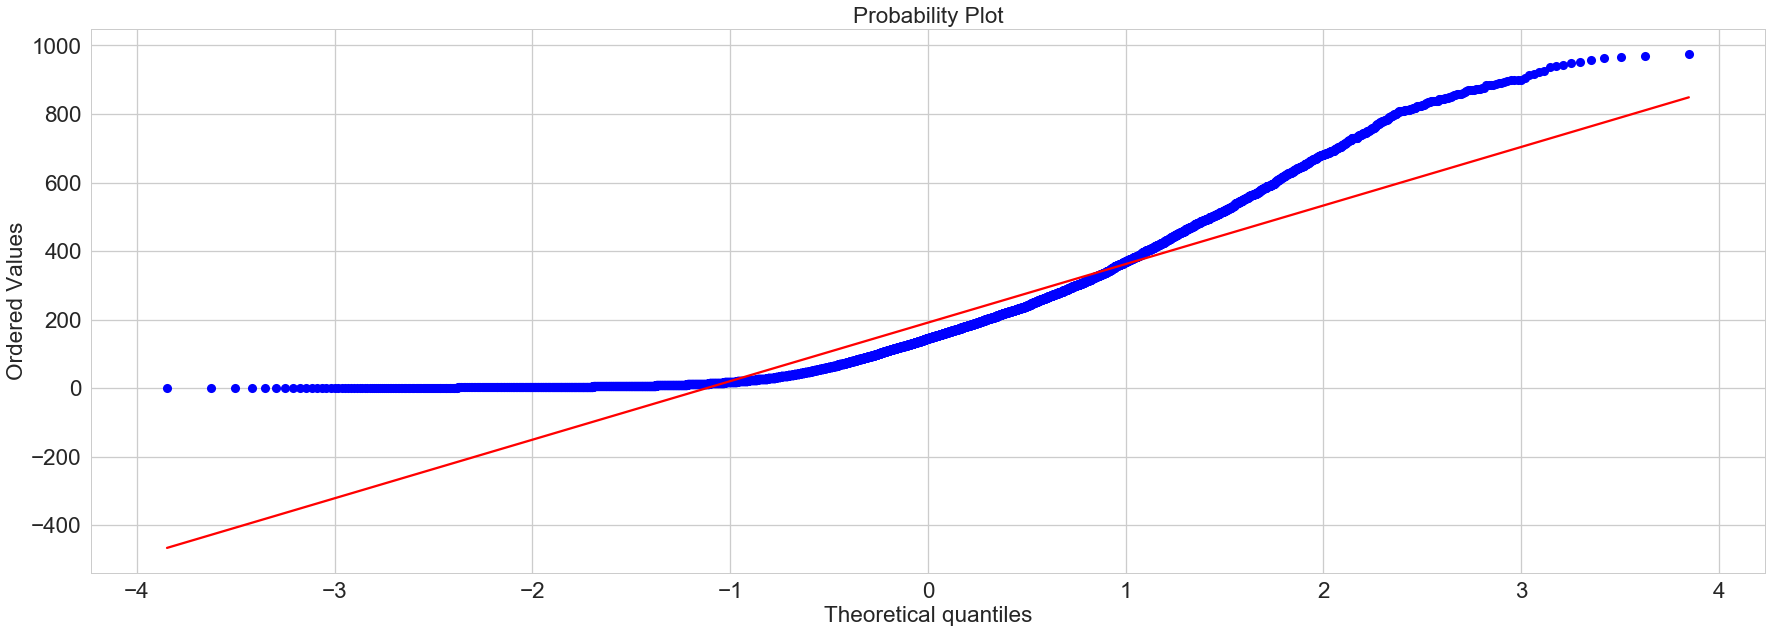

In [32]:
# normality test
stats.probplot(y.total_count.tolist(), dist="norm", plot=plt)
plt.show()

In [38]:
def fit_transform_ohe(df,col_name):
    """This function performs one hot encoding for the specified
    column.
    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        col_name: the column to be one hot encoded
    Returns:
        tuple: label_encoder, one_hot_encoder, transformed column as pandas Series
    """
    # label encode the column
    le = preprocessing.LabelEncoder()
    le_labels = le.fit_transform(df[col_name])
    df[col_name+'_label'] = le_labels
    # one hot encoding
    ohe = preprocessing.OneHotEncoder()
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    return le,ohe,features_df

# given label encoder and one hot encoder objects, 
# encode attribute to ohe
def transform_ohe(df,le,ohe,col_name):
    """This function performs one hot encoding for the specified
        column using the specified encoder objects.

    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        le(Label Encoder): the label encoder object used to fit label encoding
        ohe(One Hot Encoder): the onen hot encoder object used to fit one hot encoding
        col_name: the column to be one hot encoded

    Returns:
        tuple: transformed column as pandas Series

    """
    # label encode
    col_labels = le.transform(df[col_name])
    df[col_name+'_label'] = col_labels
    
    # ohe 
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return features_df

In [26]:
# split data into training and testing datasets
X, X_test, y, y_test = train_test_split(df_hour.iloc[:,0:-3],
                                        df_hour.iloc[:,-1],
                                        test_size=0.33,
                                        random_state=42)

X.reset_index(inplace=True)
y = y.reset_index()

X_test.reset_index(inplace=True)
y_test = y_test.reset_index()

In [27]:
# encode categorical variables
cat_attr_list = ['season','is_holiday',
                 'weather_condition','is_workingday',
                 'hour','weekday','month','year']

encoded_attr_list = []
for col in cat_attr_list:
    return_obj = fit_transform_ohe(X,col)
    encoded_attr_list.append({'label_enc':return_obj[0],
                              'ohe_enc':return_obj[1],
                              'feature_df':return_obj[2],
                              'col_name':col})

In [31]:
numeric_feature_cols = ['temp','humidity','windspeed','hour','weekday','month','year']
subset_cat_features =  ['season','is_holiday','weather_condition','is_workingday']

feature_df_list = [X[numeric_feature_cols]]
feature_df_list.extend([enc['feature_df'] \
                                 for enc in encoded_attr_list \
                                        if enc['col_name'] in subset_cat_features])

train_df_new = pd.concat(feature_df_list, axis=1)
print("Shape::{}".format(train_df_new.shape))

Shape::(11643, 19)


### Linear Regression - Training

In [33]:
X = train_df_new
y= y.total_count.values.reshape(-1,1)

lin_reg = linear_model.LinearRegression()

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


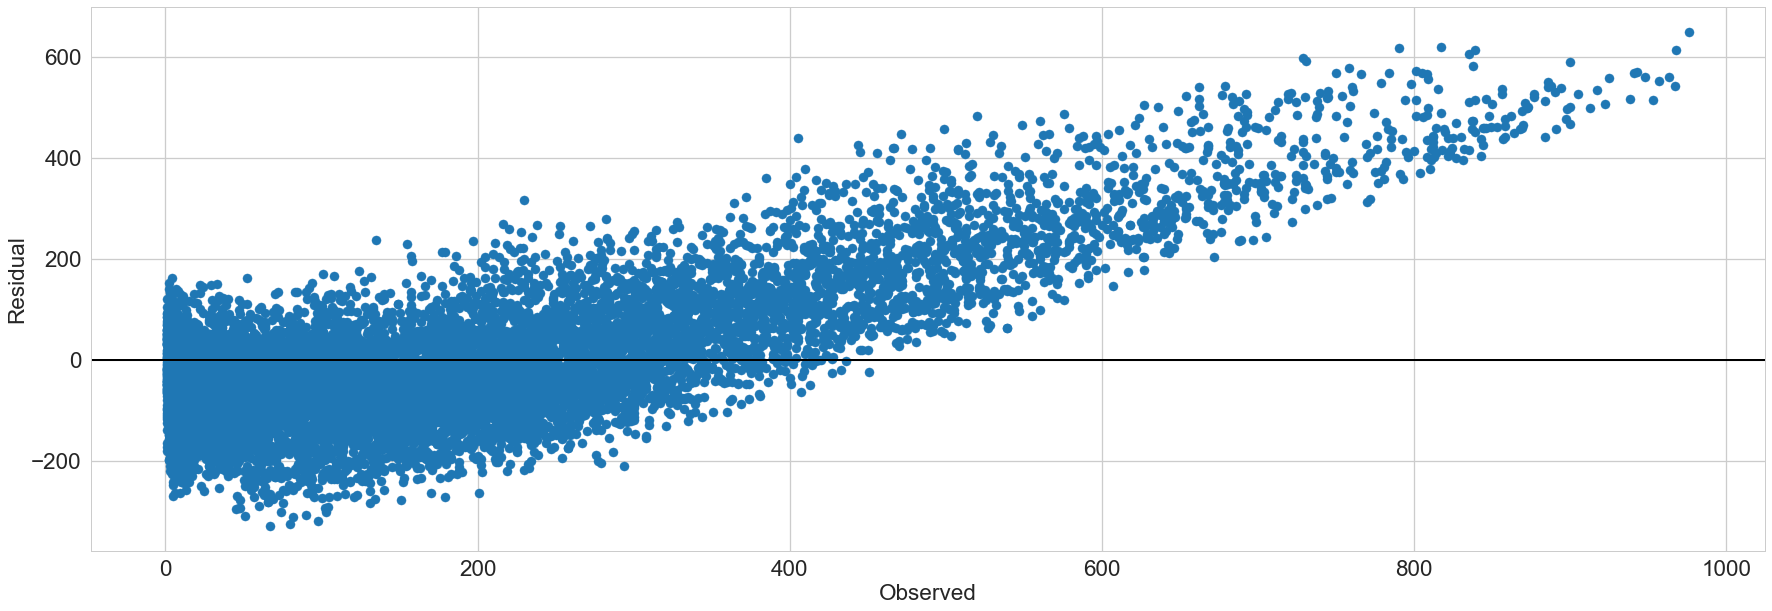

In [34]:
predicted = cross_val_predict(lin_reg, X, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, y-predicted)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

The plot above clearly violates the homoscedasticity assumption, which is about residuals being random and not following any pattern. To further quantify our findings related to the model, we plot the cross-validation scores. We use the cross_val_score() function available again as part of the model_selection module.

In [35]:
r2_scores = cross_val_score(lin_reg, X, y, cv=10)
mse_scores = cross_val_score(lin_reg, X, y, cv=10,scoring='neg_mean_squared_error')

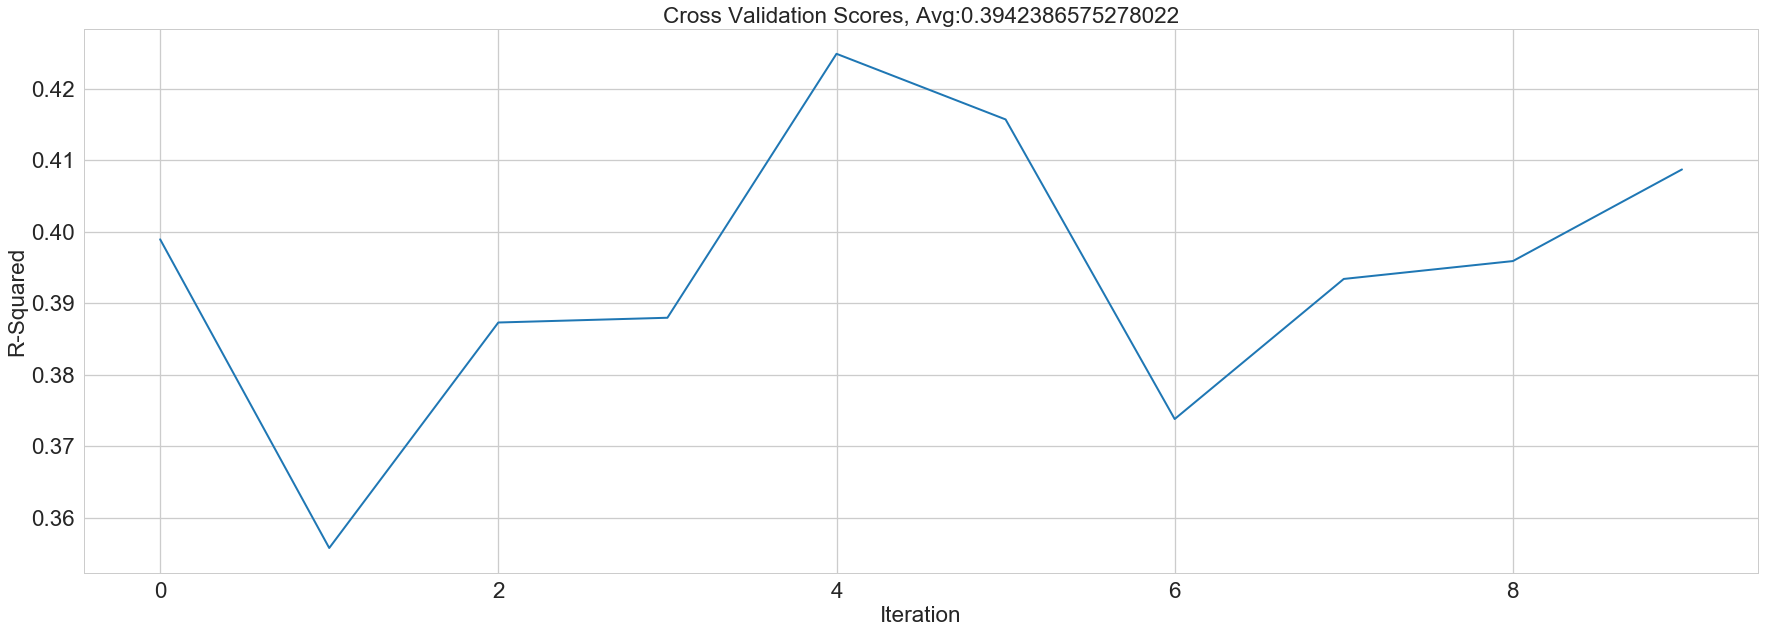

In [36]:
fig, ax = plt.subplots()
ax.plot([i for i in range(len(r2_scores))],r2_scores,lw=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('R-Squared')
ax.title.set_text("Cross Validation Scores, Avg:{}".format(np.average(r2_scores)))
plt.show()

In [37]:
print("R-squared::{}".format(r2_scores))
print("MSE::{}".format(mse_scores))

R-squared::[0.3989377  0.35575732 0.3873037  0.38796861 0.42489499 0.41571442
 0.37379762 0.39339864 0.39589746 0.40871611]
MSE::[-19612.60856671 -20800.77110185 -20256.54013607 -18545.99033804
 -18746.57816436 -21015.25565425 -21549.12876053 -21567.27946203
 -21044.42416385 -18899.05989574]


In [39]:
lin_reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

The r-squared or the coefficient of determination is 0.39 on an average for 10-fold cross validation. This points to the fact that the predictor is only able to explain 39% of the variance in the target variable.

### Testing

In [40]:
test_encoded_attr_list = []
for enc in encoded_attr_list:
    col_name = enc['col_name']
    le = enc['label_enc']
    ohe = enc['ohe_enc']
    test_encoded_attr_list.append({'feature_df':transform_ohe(X_test,
                                                              le,ohe,
                                                              col_name),
                                   'col_name':col_name})
    
    
test_feature_df_list = [X_test[numeric_feature_cols]]
test_feature_df_list.extend([enc['feature_df'] \
                             for enc in test_encoded_attr_list \
                             if enc['col_name'] in subset_cat_features])

test_df_new = pd.concat(test_feature_df_list, axis=1) 
print("Shape::{}".format(test_df_new.shape))

Shape::(5736, 19)


In [41]:
test_df_new.head()

,temp,humidity,windspeed,hour,weekday,month,year,season_1,season_2,season_3,season_4,is_holiday_0,is_holiday_1,weather_condition_1,weather_condition_2,weather_condition_3,weather_condition_4,is_workingday_0,is_workingday_1
0,0.80,0.27,0.1940,19,6,6,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.24,0.41,0.2239,20,1,1,1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.32,0.66,0.2836,2,5,10,0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.78,0.52,0.3582,19,2,5,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.26,0.56,0.3881,0,4,1,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [42]:
X_test = test_df_new
y_test = y_test.total_count.values.reshape(-1,1)

y_pred = lin_reg.predict(X_test)

residuals = y_test-y_pred

In [43]:
r2_score = lin_reg.score(X_test,y_test)
print("R-squared::{}".format(r2_score))
print("MSE: %.2f"
      % metrics.mean_squared_error(y_test, y_pred))

R-squared::0.4024409682673428
MSE: 19063.00


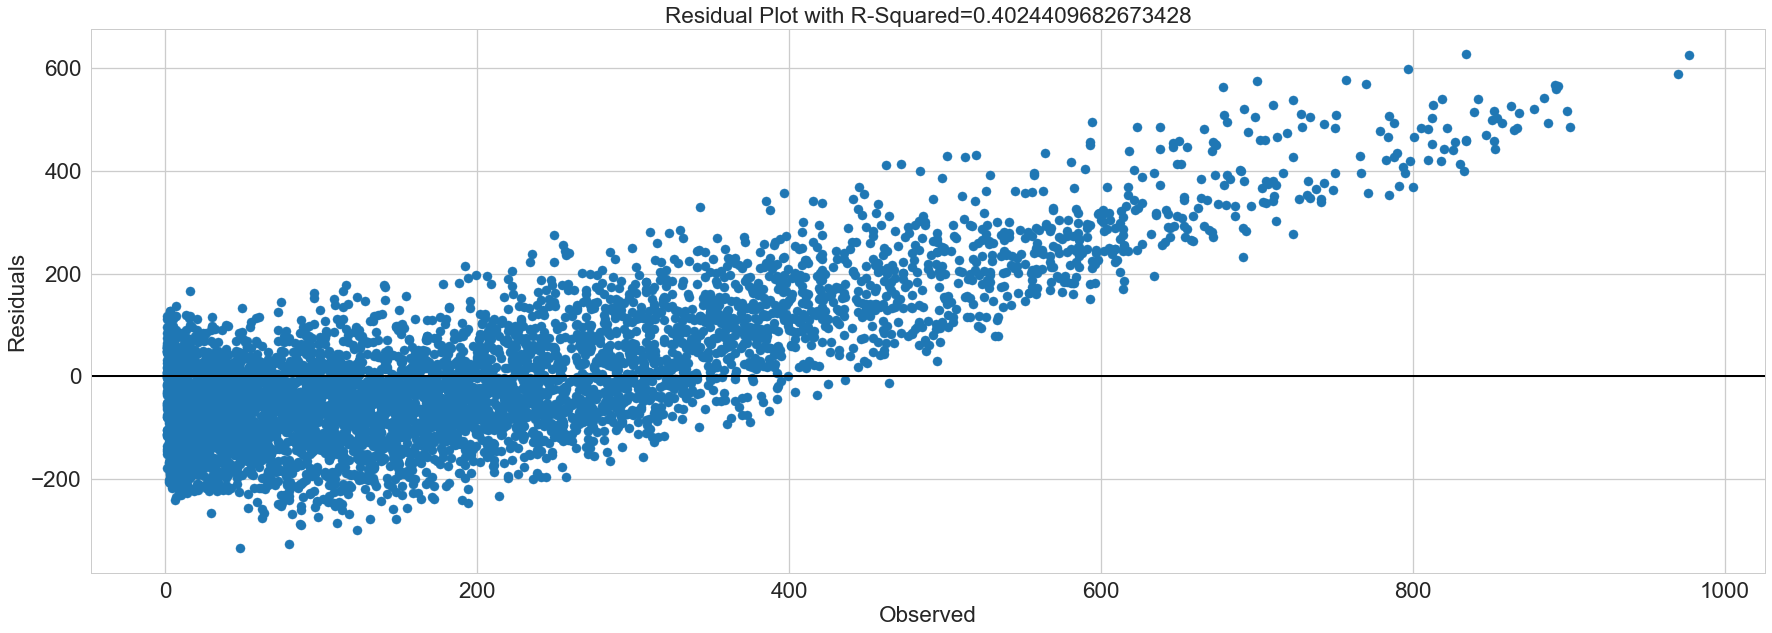

In [44]:
fig, ax = plt.subplots()
ax.scatter(y_test, residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residuals')
ax.title.set_text("Residual Plot with R-Squared={}".format(np.average(r2_score)))
plt.show()

It is clearly evident from our evaluation that the linear regression model is unable to model the data to generate decent results. Though it should be noted that the model is performing equally on both training and testing datasets. It seems like a case where we would need to model this data using methods that can model non-linear relationships.

## Decision Tree Based Regression
Decision trees are supervised learning algorithms used for both regression and classification problems. They are simple yet powerful in modeling non-linear relationships. Being a non-parametric model, the aim of this algorithm is to learn a model that can predict outcomes based on simple decision rules (for instance, if-else conditions) based on features. The interpretability of decision trees makes them even more lucrative, as we can visualize the rules it has inferred from the data. A decision tree starts off at the root and divides the dataset into two or more non-overlapping subsets, each represented as child node of the root. It divides the root into subsets based on a specific attribute. It goes on performing the split at every node until a leaf node is achieved where the target value is available.

### Node Splitting
Decision trees work in a top-down manner and node splitting is an important concept for any decision tree algorithm. Most algorithms follow a greedy approach to divide the input space into subsets.
The basic process in simple terms is to try and split data points using different attributes/features and test against a cost function. The split resulting in least cost is selected at every step. Classification and regression problems use different set of cost functions. Some of the most common ones are as follows:
* **Mean Squared Error (MSE):** Used mainly for regression trees, it is calculated as the square of difference between observed and predicted values.
* **Mean Absolute Error:**  Used for regression trees, it is similar to MSE though we only use the difference between the observed and predicted values.
* **Variance Reduction:** This was first introduced with CART algorithm, and it uses the standard formula of variance and we choose the split that results in least variance.
* **Gini Impurity/Index:** Mainly used by classification trees, it is a measure of a randomly chosen data point to have an incorrect label given it was labeled randomly.
* **Information Gain:** Again used mainly for classification problems, it is also termed as entropy. We choose the splits based on the amount of information gain. The higher information gain, the better it is.

### Stopping Criterea
As mentioned, decision trees follow greedy recursive splitting of nodes, but how or when do they stop? There are many strategies applied to define the stopping criteria. The most common being the minimum count
of data points. Node splitting is stopped if further splitting would violate this constraint. Another constraint used is the depth of the tree.
The stopping criteria together with other parameters help us achieve trees that can generalize well. A tree that is very deep or has too many non-leaf nodes often results in overfitting.

### Hyperparameters
Hyperparameters are the knobs and controls we set with an aim to optimize the model’s performance on unseen data. These hyperparameters are different from parameters which are learned by our learning algorithm over the course of training process. Hyperparameters help us achieve objectives of avoiding overfitting and so on.

Maximum depth, minimum samples for leaf nodes, minimum samples to split internal nodes, maximum leaf nodes, and so on are some of the hyperparameters actively used to improve performance of decision trees. We will use techniques like grid search to identify optimal values for these hyperparameters in the coming sections.

### Decision Tree Algorithms
Decision trees have been around for quite some time now. They have evolved with improvements in algorithms based on different techniques over the years. Some of the most commonly used algorithms are listed as follows:
* CART or Classification And Regression Tree
* ID3 or Iterative Dichotomizer 3
* C4.5

### Training
Similar to the process with linear regression, we will use the same preprocessed dataframe train_df_new with categoricals transformed into one hot encoded form along with other numerical attributes. We also split the dataset into train and test again using the train_test_split() utility from scikit-learn.

The training process for decision trees is a bit involved and different as compared to linear regression. Even though we performed cross validation while training our linear regression model, we did not have any hyperparameters to tune. In the case of decision trees, we have quite a handful of them (some of which we even discussed in the previous section). Before we get into the specifics of obtaining optimal hyperparameters, we will look at the DecisionTreeRegressor from sklearn’s tree module. We do so by instantiating a regressor object with some of the hyperparameters set as follows.

In [48]:
dtr = DecisionTreeRegressor(max_depth=4,
                            min_samples_split=5,
                            max_leaf_nodes=10)

In [49]:
dtr.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=10, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [50]:
dtr.score(X,y)

0.6056576562103779

In [53]:
dot_data = tree.export_graphviz(dtr, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
graph.write_pdf("bikeshare.pdf")

InvocationException: GraphViz's executables not found